In [ ]:
!pip install datasets==3.6.0 -q
!pip install transformers -q
!pip install torchaudio -q
!pip install librosa -q
!pip install jiwer -q
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset, Audio
import jiwer
import evaluate
from datasets import load_dataset_builder, Split
import torch
import torchaudio
from datasets import concatenate_datasets

In [ ]:
# Explicit builder
builder = load_dataset_builder(
    "tobiolatunji/afrispeech-200",
    name="pidgin"
)

# Run dataset script
builder.download_and_prepare()

# Create dataset
pidgin_speech = builder.as_dataset()

pidgin_speech = pidgin_speech.cast_column("audio", Audio(sampling_rate=16_000))

train_ds = pidgin_speech[Split.TRAIN]
dev_ds   = pidgin_speech[Split.VALIDATION]
test_ds  = pidgin_speech[Split.TEST]

train_ds = concatenate_datasets([train_ds, dev_ds])

In [ ]:
len(train_ds)

465

In [ ]:
train_ds[464]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a3f42e0148ad9fcfaf67cde027844bf44fd35ed12ded3d97171a7c2e8be161be/c5317790-d70e-419e-a41c-6c1e9bc71a94/e4d264941ba6d8b05c6a27e990c7be42.wav',
 'array': array([ 0.00092411, -0.00029846, -0.0008057 , ..., -0.00103839,
        -0.00094252, -0.00097053]),
 'sampling_rate': 16000}

In [ ]:
print(type(pidgin_speech))
print(train_ds[0].keys())
print(train_ds[0]["audio"])
print(train_ds[0]["transcript"])

<class 'datasets.dataset_dict.DatasetDict'>
dict_keys(['speaker_id', 'path', 'audio_id', 'audio', 'transcript', 'age_group', 'gender', 'accent', 'domain', 'country', 'duration'])
{'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3aab06d7adcc9ac723155ef0.wav', 'array': array([-2.71281897e-06,  1.88387174e-03,  9.64534353e-04, ...,
        9.25352448e-04,  1.24268816e-03,  2.32251361e-03]), 'sampling_rate': 16000}
Pt had been given ambient at 1am for complaints of being unable to sleep.


In [ ]:
# This is used when Fine-Tune for subgroups
COLUMNS_TO_REMOVE = ["speaker_id", "audio_id", "duration", "country"]

In [ ]:
train_ds = train_ds.remove_columns(COLUMNS_TO_REMOVE)
# dev_ds   = dev_ds.remove_columns(COLUMNS_TO_REMOVE)
test_ds  = test_ds.remove_columns(COLUMNS_TO_REMOVE)

In [ ]:
train_ds.features

{'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'transcript': Value(dtype='string', id=None),
 'age_group': Value(dtype='string', id=None),
 'gender': Value(dtype='string', id=None),
 'accent': Value(dtype='string', id=None),
 'domain': Value(dtype='string', id=None)}

In [ ]:
SUBGROUP_COLS = ["age_group", "gender", "domain"]

def add_subgroup(dataset):
    dataset["subgroup"] = "|".join(
        str(dataset[c]) for c in SUBGROUP_COLS
    )
    return dataset

train_ds = train_ds.map(add_subgroup)
# dev_ds   = dev_ds.map(add_subgroup)
test_ds  = test_ds.map(add_subgroup)

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
from collections import Counter

subgroup_counts = Counter(train_ds["subgroup"])

def add_sample_weight(example):
    example["sample_weight"] = 1.0 / subgroup_counts[example["subgroup"]]
    return example

train_ds = train_ds.map(add_sample_weight)

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

In [ ]:
train_ds[5]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/6982c206-b872-4089-aac3-90772d8100fa/99e7a2db8dba9e004c0e254967212499.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/6982c206-b872-4089-aac3-90772d8100fa/99e7a2db8dba9e004c0e254967212499.wav',
  'array': array([-4.72290230e-05, -4.10524721e-04, -3.45156936e-04, ...,
         -2.70698057e-03, -1.40225585e-03, -6.96701580e-04]),
  'sampling_rate': 16000},
 'transcript': 'fans of miley cyrus here a piece of good news your favourite pop star is back again with a brand new song',
 'age_group': '41-55',
 'gender': 'Male',
 'accent': 'pidgin',
 'domain': 'general',
 'subgroup': '41-55|Male|general',
 'sample_weight': 0.011363636363636364}

In [ ]:
train_df = train_ds.to_pandas()
# dev_df   = dev_ds.to_pandas()
test_df  = test_ds.to_pandas()

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(train_df["transcript"])

,transcript
345,primum defects are part of a more complex lesion and are best considered as incomplete atrioventricular septal defects
451,question of slightly rotated labia majora versus wasted appearance of skin
433,tf cckgday enteral feeds at cckgday bmsc pn dil at cckgday
37,as with all the numbers swirling around the pandemic more than million cases and deaths worldwide these are challenging to grasp
187,qd meds given at olawuyin akukwe lipitor etc
4,and according to the sun prince harry has always been star struck over hollywood so it wont have been hard for her to persuade him the former member of her inner circle said
55,uo approx ccs per hr
217,osoo infant remains on tf cck day of pe via ngttolerating well no spits or aspirates voiding well no stool abd
178,no bm on commode
216,the lawsuits consolidated before polster accuse drugmakers distributors and pharmacy chains of fueling an opioid crisis blamed for us overdose deaths since


In [ ]:
import re

chars_to_ignore_regex = r'[,\?\.\!\-\;\:\"\“\%\‘\”\�\—\/\>\+\(\)\*\xa0\–\n0-9\"]'

def remove_special_characters(batch):
    batch["transcript"] = re.sub(chars_to_ignore_regex, '', batch["transcript"]).lower()
    return batch

In [ ]:
train_ds = train_ds.map(remove_special_characters)
# dev_ds   = dev_ds.map(remove_special_characters)
test_ds  = test_ds.map(remove_special_characters)

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
show_random_elements(train_ds.remove_columns(["audio", "path", "gender", "age_group", "domain"]))

,transcript,accent,subgroup,sample_weight
0,unspecified injury of duodenum subsequent encounter tablet oral acetaminophen and codeine phosphate acetaminophen codeine phosphate mgmg laceration with foreign body of right hand subsequent encounter,pidgin,26-40|Female|clinical,0.016667
1,the gold standard for the evaluation of valvular heart disease is transthoracic echocardiography tte,pidgin,19-25|Female|clinical,0.100000
2,make every effort to go and see the patient for yourself as your immediate first impressions can provide much more information than can be obtained by several minutes of discussion by telephone if patients look sick they probably are,pidgin,19-25|Male|clinical,0.006849
3,resp continues on cpappssatss lsc clourse at base,pidgin,26-40|Female|clinical,0.016667
4,for people looking at shoreview or arden hills but cant afford them the next city north is circle pines blaine and lino lakes he said,pidgin,41-55|Male|general,0.011364
5,obiomadad called for update,pidgin,19-25|Male|clinical,0.006849
6,discharge instructions by sebe choro dear ms edowoo baca,pidgin,19-25|Male|general,0.013514
7,ps was reduced due to hypocarbia,pidgin,26-40|Female|clinical,0.016667
8,small spit after afternoon feed,pidgin,19-25|Male|clinical,0.006849
9,a jury concluded that these methods were fraudulent while it also found them guilty of possessing articles for fraud namely software used for harvesting tickets,pidgin,19-25|Male|general,0.013514


In [ ]:
train_ds[1]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/203748b3-b767-4575-8bc6-10c97601a89f/2f846afb5143b61c6317880bfbe7d7e2.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/203748b3-b767-4575-8bc6-10c97601a89f/2f846afb5143b61c6317880bfbe7d7e2.wav',
  'array': array([ 0.00314715,  0.0063228 ,  0.0027286 , ..., -0.00227166,
         -0.00158122, -0.00194208]),
  'sampling_rate': 16000},
 'transcript': 'for example immuno blotting analysis will determine the presence and the quantity of a protein in a given cellular condition and its relative molecular weight',
 'age_group': '19-25',
 'gender': 'Male',
 'accent': 'pidgin',
 'domain': 'clinical',
 'subgroup': '19-25|Male|clinical',
 'sample_weight': 0.00684931506849315}

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["transcript"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

# Merging all transcripts and extracts characters only

In [ ]:
vocab_train = train_ds.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=train_ds.column_names)
# vocab_dev = dev_ds.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dev_ds.column_names)
vocab_test = test_ds.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=test_ds.column_names)

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

{' ': 0,
 "'": 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '’': 28}

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
del vocab_dict["’"]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

In [ ]:
vocab_dict.items()

dict_items([("'", 1), ('a', 2), ('b', 3), ('c', 4), ('d', 5), ('e', 6), ('f', 7), ('g', 8), ('h', 9), ('i', 10), ('j', 11), ('k', 12), ('l', 13), ('m', 14), ('n', 15), ('o', 16), ('p', 17), ('q', 18), ('r', 19), ('s', 20), ('t', 21), ('u', 22), ('v', 23), ('w', 24), ('x', 25), ('y', 26), ('z', 27), ('|', 0), ('[UNK]', 28), ('[PAD]', 29)])

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./",
                                                 unk_token="[UNK]",
                                                 pad_token="[PAD]",
                                                 word_delimiter_token="|",
                                                 eos_token=None,
                                                 bos_token=None)

In [ ]:
from transformers import SeamlessM4TFeatureExtractor

feature_extractor = SeamlessM4TFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")

In [ ]:
from transformers import Wav2Vec2BertProcessor

processor = Wav2Vec2BertProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
train_ds[0]["path"]

'/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3aab06d7adcc9ac723155ef0.wav'

In [ ]:
train_ds[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3aab06d7adcc9ac723155ef0.wav',
 'array': array([-2.71281897e-06,  1.88387174e-03,  9.64534353e-04, ...,
         9.25352448e-04,  1.24268816e-03,  2.32251361e-03]),
 'sampling_rate': 16000}

In [ ]:
import re

def normalize_whitespace(batch):
    batch["transcript"] = re.sub(r"\s+", " ", batch["transcript"]).strip()
    return batch

In [ ]:
train_ds = train_ds.map(normalize_whitespace)
# dev_ds   = dev_ds.map(normalize_whitespace)
test_ds  = test_ds.map(normalize_whitespace)

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
test_ds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/ec1b6cdcc439d2ab20deba5dfdf6b3615c35553435f484b4fc8f3b975f7513cf/d4336ca9-6f12-4115-9a5f-e5906b05e05e/e018849df98411babb1145697096baeb.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/ec1b6cdcc439d2ab20deba5dfdf6b3615c35553435f484b4fc8f3b975f7513cf/d4336ca9-6f12-4115-9a5f-e5906b05e05e/e018849df98411babb1145697096baeb.wav',
  'array': array([-0.0029954 , -0.00280054,  0.00355052, ...,  0.00048989,
          0.00064457,  0.00061211]),
  'sampling_rate': 16000},
 'transcript': 'she was selected best young player awards in season',
 'age_group': '',
 'gender': 'Female',
 'accent': 'pidgin',
 'domain': 'general',
 'subgroup': '|Female|general'}

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_ds)-1)
print(train_ds[rand_int]["transcript"])
ipd.Audio(data=train_ds[rand_int]["audio"]["array"], autoplay=False, rate=16000)

mozambique who began their campaign by drawing with rwanda could close the gap behind senegal to two points by winning away to bottom team benin on wednesday


In [ ]:
print("Target text:", train_ds[rand_int]["transcript"])
print("Input array shape:", train_ds[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_ds[rand_int]["audio"]["sampling_rate"])

Target text: mozambique who began their campaign by drawing with rwanda could close the gap behind senegal to two points by winning away to bottom team benin on wednesday
Input array shape: (215216,)
Sampling rate: 16000


In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["input_length"] = len(batch["input_features"])

    batch["labels"] = processor(text=batch["transcript"]).input_ids
    return batch

In [ ]:
test_ds

Dataset({
    features: ['path', 'audio', 'transcript', 'age_group', 'gender', 'accent', 'domain', 'subgroup'],
    num_rows: 45
})

In [ ]:
train_ds

Dataset({
    features: ['path', 'audio', 'transcript', 'age_group', 'gender', 'accent', 'domain', 'subgroup', 'sample_weight'],
    num_rows: 465
})

In [ ]:
# This is used when Fine-Tune for subgroups
COLUMNS_TO_REMOVE = ["audio", "transcript", "path"]

In [ ]:
# train_ds_p = train_ds.map(prepare_dataset, remove_columns=train_ds.column_names, batch_size=16, batched=True)
train_ds_p = train_ds.map(prepare_dataset, remove_columns=COLUMNS_TO_REMOVE)
# dev_ds_p   = dev_ds.map(prepare_dataset, remove_columns=dev_ds.column_names)
test_ds_p = test_ds.map(prepare_dataset, remove_columns=COLUMNS_TO_REMOVE)

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
train_ds_p[0]

{'age_group': '19-25',
 'gender': 'Male',
 'accent': 'pidgin',
 'domain': 'clinical',
 'subgroup': '19-25|Male|clinical',
 'sample_weight': 0.00684931506849315,
 'input_features': [[-1.1402342319488525,
   -1.139947533607483,
   -1.507064938545227,
   -1.6882773637771606,
   -1.6411494016647339,
   -1.2515580654144287,
   -0.9078049659729004,
   -0.694169819355011,
   -0.5842520594596863,
   -0.990763783454895,
   -0.832976758480072,
   -0.6925557255744934,
   -0.5217511653900146,
   -0.5965626239776611,
   -0.39992794394493103,
   -0.24529515206813812,
   -0.18651145696640015,
   -0.33929744362831116,
   -0.4555588364601135,
   -0.31424960494041443,
   -0.07465158402919769,
   -0.27134451270103455,
   -0.41004422307014465,
   0.013315744698047638,
   0.07767082750797272,
   -0.07984514534473419,
   -0.24381881952285767,
   0.023570891469717026,
   -0.12297296524047852,
   -0.5027801990509033,
   -0.6265169382095337,
   -0.5112144947052002,
   0.027374202385544777,
   0.318268537521362

In [ ]:
max_input_length_in_sec = 10.0
train_ds_p = train_ds_p.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2BertProcessor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        labels_batch = self.processor.pad(
            labels=label_features,
            padding=self.padding,
            return_tensors="pt",
        )
        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
metric = evaluate.load("wer")

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Wav2Vec2BertForCTC

model = Wav2Vec2BertForCTC.from_pretrained(
    "facebook/w2v-bert-2.0",
    # Regularization
    attention_dropout=0.001, # Dropout applied to self-attention weights (regularizes attention heads)
    hidden_dropout=0.01, # Dropout on hidden states inside transformer layers (prevents overfitting)
    feat_proj_dropout=0.001, # Dropout after projecting CNN features → transformer dimension
    layerdrop=0.0, # Randomly drops entire transformer layers during training

    # Spec Augment
    mask_time_prob=0.05, # Probability of masking time-steps during pretraining-style augmentation
    # mask_time_length=10,

    # CTC Loss
    ctc_loss_reduction="mean",

    # Adapter
    add_adapter=True,

    # Tokenizer
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

Some weights of Wav2Vec2BertForCTC were not initialized from the model checkpoint at facebook/w2v-bert-2.0 and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2_bert.adapter.layers.0.ffn.intermediate_dense.bias', 'wav2vec2_bert.adapter.layers.0.ffn.intermediate_dense.weight', 'wav2vec2_bert.adapter.layers.0.ffn.output_dense.bias', 'wav2vec2_bert.adapter.layers.0.ffn.output_dense.weight', 'wav2vec2_bert.adapter.layers.0.ffn_layer_norm.bias', 'wav2vec2_bert.adapter.layers.0.ffn_layer_norm.weight', 'wav2vec2_bert.adapter.layers.0.residual_conv.bias', 'wav2vec2_bert.adapter.layers.0.residual_conv.weight', 'wav2vec2_bert.adapter.layers.0.residual_layer_norm.bias', 'wav2vec2_bert.adapter.layers.0.residual_layer_norm.weight', 'wav2vec2_bert.adapter.layers.0.self_attn.linear_k.bias', 'wav2vec2_bert.adapter.layers.0.self_attn.linear_k.weight', 'wav2vec2_bert.adapter.layers.0.self_attn.linear_out.bias', 'wav2vec2_bert.adapter.layers.0.self_attn.linear_out.weight', 'wav2vec2_ber

In [ ]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader

class FairnessTrainer(Trainer):
    def get_train_dataloader(self):
        generator = torch.Generator()
        generator.manual_seed(self.args.seed)

        sampler = WeightedRandomSampler(
            weights=torch.tensor(self.train_dataset["sample_weight"], dtype=torch.double),
            num_samples=len(self.train_dataset),
            replacement=True,
            generator=generator,
        )

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            pin_memory=False,
            num_workers=0,
        )

In [ ]:
from transformers import set_seed
SEED = 39
set_seed(SEED)

In [ ]:
if hasattr(model, "freeze_feature_extractor"):
  model.freeze_feature_extractor()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="w2v-bert-pidgin",

  seed=SEED,
  data_seed=SEED,

  per_device_train_batch_size=16,
  # per_device_eval_batch_size=8,

  group_by_length=True,
  gradient_checkpointing=True,

  learning_rate=5e-5,
  warmup_ratio=0.1,
  num_train_epochs=30,

  fp16=True,

  dataloader_num_workers=0,
  dataloader_pin_memory=False,
  save_total_limit=2,

  eval_strategy="epoch",
  save_strategy="epoch",
  include_inputs_for_metrics=False,

  logging_strategy="epoch",

  load_best_model_at_end=True,
  metric_for_best_model="wer",
  greater_is_better=False,
  remove_unused_columns=False,
  disable_tqdm=False,
  report_to=["tensorboard"],
)

In [ ]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = FairnessTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds_p,
    eval_dataset=test_ds_p,
    tokenizer=processor,
)

/tmp/ipython-input-293045507.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FairnessTrainer.__init__`. Use `processing_class` instead.
  trainer = FairnessTrainer(


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Wer
1,5.492400,3.079025,100.000000
2,3.138600,2.956551,100.000000
3,2.653700,2.306104,98.985507
4,1.412500,1.319916,75.362319
5,0.850200,1.178204,65.507246
6,0.549100,1.172307,60.000000
7,0.423100,1.033220,56.811594
8,0.306500,1.095693,56.666667
9,0.224700,1.071748,51.449275
10,0.181200,1.066513,51.014493


TrainOutput(global_step=900, training_loss=0.5391741186380387, metrics={'train_runtime': 4078.9679, 'train_samples_per_second': 3.42, 'train_steps_per_second': 0.221, 'total_flos': 1.0169709785788338e+19, 'train_loss': 0.5391741186380387, 'epoch': 30.0})

In [ ]:
logs = trainer.state.log_history

In [ ]:
logs

[{'loss': 5.4924,
  'grad_norm': 8.01009464263916,
  'learning_rate': 1.074074074074074e-05,
  'epoch': 1.0,
  'step': 30},
 {'eval_loss': 3.07902455329895,
  'eval_wer': 100.0,
  'eval_runtime': 2.5781,
  'eval_samples_per_second': 17.455,
  'eval_steps_per_second': 2.327,
  'epoch': 1.0,
  'step': 30},
 {'loss': 3.1386,
  'grad_norm': 16.386886596679688,
  'learning_rate': 2.1851851851851852e-05,
  'epoch': 2.0,
  'step': 60},
 {'eval_loss': 2.9565510749816895,
  'eval_wer': 100.0,
  'eval_runtime': 2.5706,
  'eval_samples_per_second': 17.506,
  'eval_steps_per_second': 2.334,
  'epoch': 2.0,
  'step': 60},
 {'loss': 2.6537,
  'grad_norm': 16.273696899414062,
  'learning_rate': 3.2962962962962964e-05,
  'epoch': 3.0,
  'step': 90},
 {'eval_loss': 2.3061041831970215,
  'eval_wer': 98.98550724637681,
  'eval_runtime': 2.9329,
  'eval_samples_per_second': 15.343,
  'eval_steps_per_second': 2.046,
  'epoch': 3.0,
  'step': 90},
 {'loss': 1.4125,
  'grad_norm': 6.497519493103027,
  'learn

In [ ]:
import pandas as pd

rows = []

for log in logs:
    row = {}
    if "loss" in log:
        row["epoch"] = log.get("epoch")
        row["train_loss"] = log["loss"]
    if "eval_wer" in log:
        row["epoch"] = log.get("epoch")
        row["wer"] = log["eval_wer"]
    if row:
        rows.append(row)

df = pd.DataFrame(rows)
df = df.groupby("epoch").mean().reset_index()
print(df)

    epoch  train_loss         wer
0     1.0      5.4924  100.000000
1     2.0      3.1386  100.000000
2     3.0      2.6537   98.985507
3     4.0      1.4125   75.362319
4     5.0      0.8502   65.507246
5     6.0      0.5491   60.000000
6     7.0      0.4231   56.811594
7     8.0      0.3065   56.666667
8     9.0      0.2247   51.449275
9    10.0      0.1812   51.014493
10   11.0      0.1445   50.144928
11   12.0      0.1311   48.840580
12   13.0      0.1232   45.072464
13   14.0      0.0855   45.652174
14   15.0      0.0654   45.507246
15   16.0      0.0631   44.927536
16   17.0      0.0521   44.347826
17   18.0      0.0609   42.753623
18   19.0      0.0501   44.782609
19   20.0      0.0405   43.913043
20   21.0      0.0304   42.463768
21   22.0      0.0174   43.043478
22   23.0      0.0178   44.347826
23   24.0      0.0111   41.884058
24   25.0      0.0099   41.884058
25   26.0      0.0130   42.173913
26   27.0      0.0064   41.449275
27   28.0      0.0096   42.608696
28   29.0     

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


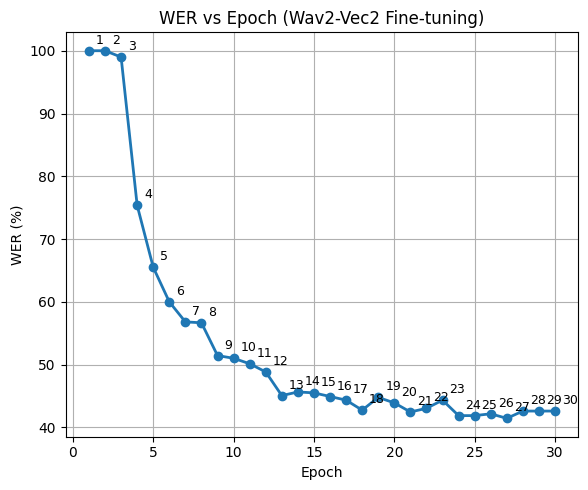

📁 Plot saved to: /content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/wer_vs_epoch_Seed_23.png


In [ ]:
import os
import matplotlib.pyplot as plt

# keep only first 7 epochs
df_plot = df[df["epoch"] <= 30].sort_values("epoch")

plt.figure(figsize=(6,5))

plt.plot(
    df_plot["epoch"],
    df_plot["wer"],
    marker="o",
    linewidth=2
)

# annotate each point
for _, row in df_plot.iterrows():
    plt.annotate(
        f"{int(row['epoch'])}",
        (row["epoch"], row["wer"]),
        textcoords="offset points",
        xytext=(5,5),
        fontsize=9
    )

plt.xlabel("Epoch")
plt.ylabel("WER (%)")
plt.title("WER vs Epoch (Wav2-Vec2 Fine-tuning)")
plt.grid(True)
plt.tight_layout()

# save
save_dir = "/content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "wer_vs_epoch_Seed_23.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"📁 Plot saved to: {save_path}")

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import random
import numpy as np
import torch

SEED = 39

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior (important)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model.eval()

Wav2Vec2BertForCTC(
  (wav2vec2_bert): Wav2Vec2BertModel(
    (feature_projection): Wav2Vec2BertFeatureProjection(
      (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=160, out_features=1024, bias=True)
      (dropout): Dropout(p=0.001, inplace=False)
    )
    (encoder): Wav2Vec2BertEncoder(
      (dropout): Dropout(p=0.01, inplace=False)
      (layers): ModuleList(
        (0-23): 24 x Wav2Vec2BertEncoderLayer(
          (ffn1_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (ffn1): Wav2Vec2BertFeedForward(
            (intermediate_dropout): Dropout(p=0.0, inplace=False)
            (intermediate_dense): Linear(in_features=1024, out_features=4096, bias=True)
            (intermediate_act_fn): SiLU()
            (output_dense): Linear(in_features=4096, out_features=1024, bias=True)
            (output_dropout): Dropout(p=0.01, inplace=False)
          )
          (self_attn_layer_norm): LayerNorm

In [ ]:
results = []

for i, sample in enumerate(test_ds):
    inputs = processor(
        sample["audio"]["array"],
        sampling_rate=16000,
        return_tensors="pt",
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    pred_ids = torch.argmax(logits, dim=-1)
    pred_text = processor.batch_decode(pred_ids, skip_special_tokens=True)[0]

    results.append({
        "id": i,
        "reference": sample["transcript"],
        "prediction": pred_text,
        "gender": sample.get("gender"),
        "accent": sample.get("accent"),
        "domain": sample.get("domain"),
        "age_group": sample.get("age_group"),
    })

In [ ]:
refs  = [r["reference"] for r in results]
preds = [r["prediction"] for r in results]

overall_wer = jiwer.wer(refs, preds)
overall_cer = jiwer.cer(refs, preds)

print(f"Word Error Rate (WER): {overall_wer:.4f}")
print(f"Character Error Rate (CER): {overall_cer:.4f}")

Word Error Rate (WER): 0.4435
Character Error Rate (CER): 0.1507


In [ ]:
import jiwer

def wer_by_field(results, field, min_samples=3):
    values = set(r[field] for r in results if r[field] is not None)
    wer_dict = {}

    for val in values:
        subset = [r for r in results if r[field] == val]

        if len(subset) < min_samples:
            continue

        refs  = [r["reference"] for r in subset]
        preds = [r["prediction"] for r in subset]

        wer_dict[val] = jiwer.wer(refs, preds)

    return wer_dict

In [ ]:
wer_by_gender = wer_by_field(results, "gender")
wer_by_accent = wer_by_field(results, "accent")
wer_by_domain = wer_by_field(results, "domain")
wer_by_age    = wer_by_field(results, "age_group")

In [ ]:
print("Gender WER:", wer_by_gender)
print("Accent WER:", wer_by_accent)
print("Domain WER:", wer_by_domain)
print("Age Group WER:", wer_by_age)

Gender WER: {'Male': 0.4642857142857143, 'Female': 0.4161073825503356}
Accent WER: {'pidgin': 0.4434782608695652}
Domain WER: {'clinical': 0.4498714652956298, 'general': 0.43521594684385384}
Age Group WER: {'': 0.38461538461538464, '19-25': 0.44891640866873067, '<18yrs': 0.5107913669064749, '41-55': 0.423728813559322}


In [ ]:
def wer_by_intersection(results, fields, min_samples=3):
    from collections import defaultdict

    buckets = defaultdict(list)

    for r in results:
        key = "|".join(str(r[f]) for f in fields)
        buckets[key].append(r)

    wer_dict = {}

    for key, subset in buckets.items():
        if len(subset) < min_samples:
            continue

        refs  = [r["reference"] for r in subset]
        preds = [r["prediction"] for r in subset]

        wer_dict[key] = jiwer.wer(refs, preds)

    return wer_dict


wer_by_subgroup = wer_by_intersection(
    results,
    fields=["gender", "age_group", "domain"]
)

In [ ]:
print(f"Intersectional Subgroup WER: {wer_by_subgroup}")

Intersectional Subgroup WER: {'Female||general': 0.328125, 'Male|19-25|clinical': 0.4612546125461255, 'Male||general': 0.41904761904761906, 'Female|41-55|clinical': 0.423728813559322, 'Female|19-25|clinical': 0.38461538461538464, 'Female|<18yrs|general': 0.45689655172413796}


In [ ]:
BASE_DIR = "/content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/"


In [ ]:
def extract_model_params(model, processor):
    cfg = model.config

    return {
        "Model Name": cfg._name_or_path,
        "attention_dropout": cfg.attention_dropout,
        "hidden_dropout": cfg.hidden_dropout,
        "feat_proj_dropout": cfg.feat_proj_dropout,
        "mask_time_prob": cfg.mask_time_prob,
        "mask_time_length": getattr(cfg, "mask_time_length", None),
        "layerdrop": cfg.layerdrop,
        "ctc_loss_reduction": cfg.ctc_loss_reduction,
        "add_adapter": cfg.add_adapter,
        "pad_token_id": processor.tokenizer.pad_token_id,
        "vocab_size": len(processor.tokenizer),
    }

In [ ]:
extract_model_params(model, processor)

{'Model Name': 'facebook/w2v-bert-2.0',
 'attention_dropout': 0.001,
 'hidden_dropout': 0.01,
 'feat_proj_dropout': 0.001,
 'mask_time_prob': 0.05,
 'mask_time_length': 10,
 'layerdrop': 0.0,
 'ctc_loss_reduction': 'mean',
 'add_adapter': True,
 'pad_token_id': 29,
 'vocab_size': 30}

In [ ]:
import platform

In [ ]:
wer_results = {
    "config":{
        "Seed": training_args.seed,
        "modelName": training_args.run_name or training_args.output_dir,
        "language": "pidgin",
        "task": "transcribe",

        # Fairness Attributes
        "fine-tuned": "yes",
        "fairness": "yes",
        "Fairness Aware Training": "yes",
        "Subgroup_Sampling": "yes",

        # Training args
        "Compute Loss": "CTC loss mean",
        "Custom Sampler": "N/A",
        "group_by_length": training_args.group_by_length,
        "gradient_checkpointing": training_args.gradient_checkpointing,
        "num_train_epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "learning_rate": training_args.learning_rate,
        "warmup_steps": training_args.warmup_steps,
        "fp16": training_args.fp16,

        "dataloader_num_workers": training_args.dataloader_num_workers,
        "dataloader_pin_memory": training_args.dataloader_pin_memory,
        "save_total_limit": training_args.save_total_limit,
        "eval_strategy": training_args.eval_strategy,
        "save_strategy": training_args.save_strategy,
        "include_inputs_for_metrics": training_args.include_inputs_for_metrics,
        "logging_strategy": training_args.logging_strategy,
        "load_best_model_at_end": training_args.load_best_model_at_end,
        "metric_for_best_model": training_args.metric_for_best_model,
        "greater_is_better": training_args.greater_is_better,
        "remove_unused_columns": training_args.remove_unused_columns,
        "report_to": training_args.report_to,
    },
    "ColabConfig":{
        "GPU": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
        "GPU_count": torch.cuda.device_count(),
        "RAM": "Colab RAM (dynamic)",
        "CPU": platform.processor(),
    },
    "ModelParams": extract_model_params(model, processor),
    "overall": {
        "wer": overall_wer,
        "cer": overall_cer,
    },
    "by_gender": wer_by_gender,
    "by_accent": wer_by_accent,
    "by_domain": wer_by_domain,
    "by_age_group": wer_by_age,
    "wer_by_subgroup": wer_by_subgroup,
}

In [ ]:
wer_results

{'config': {'Seed': 39,
  'modelName': 'w2v-bert-pidgin',
  'language': 'pidgin',
  'task': 'transcribe',
  'fine-tuned': 'yes',
  'fairness': 'yes',
  'Fairness Aware Training': 'yes',
  'Subgroup_Sampling': 'yes',
  'Compute Loss': 'CTC loss mean',
  'Custom Sampler': 'N/A',
  'group_by_length': True,
  'gradient_checkpointing': True,
  'num_train_epochs': 30,
  'batch_size': 16,
  'learning_rate': 5e-05,
  'warmup_steps': 0,
  'fp16': True,
  'dataloader_num_workers': 0,
  'dataloader_pin_memory': False,
  'save_total_limit': 2,
  'eval_strategy': <IntervalStrategy.EPOCH: 'epoch'>,
  'save_strategy': <SaveStrategy.EPOCH: 'epoch'>,
  'include_inputs_for_metrics': False,
  'logging_strategy': <IntervalStrategy.EPOCH: 'epoch'>,
  'load_best_model_at_end': True,
  'metric_for_best_model': 'wer',
  'greater_is_better': False,
  'remove_unused_columns': False,
  'report_to': ['tensorboard']},
 'ColabConfig': {'GPU': 'NVIDIA A100-SXM4-80GB',
  'GPU_count': 1,
  'RAM': 'Colab RAM (dynamic)'

In [ ]:
import json
import os

os.makedirs(BASE_DIR, exist_ok=True)

wer_path = os.path.join(BASE_DIR, "wer_results.json")
with open(wer_path, "w") as f:
    json.dump(wer_results, f, indent=2)

print("WER results saved to:", wer_path)

WER results saved to: /content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/wer_results.json


In [ ]:
model_dir = os.path.join(BASE_DIR, "wav2vec2-bert-2.0-Pidgin_FineTuned_FairSubgroup_seed_39")

trainer.save_model(model_dir)
processor.tokenizer.save_pretrained(model_dir)
processor.feature_extractor.save_pretrained(model_dir)

print("Model saved to:", model_dir)

Model saved to: /content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/wav2vec2-bert-2.0-Pidgin_FineTuned_FairSubgroup_seed_39


In [ ]:
import pandas as pd

logs = trainer.state.log_history

logs_df = pd.DataFrame(logs)

logs_json_path = os.path.join(BASE_DIR, "training_logs.json")
logs_csv_path  = os.path.join(BASE_DIR, "training_logs.csv")

logs_df.to_json(logs_json_path, orient="records", indent=2)
logs_df.to_csv(logs_csv_path, index=False)

print("Training logs saved to:")
print(logs_json_path)
print(logs_csv_path)

Training logs saved to:
/content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/training_logs.json
/content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/training_logs.csv


In [ ]:
from transformers import Wav2Vec2BertProcessor

processor = Wav2Vec2BertProcessor.from_pretrained(model_dir)

from transformers import Wav2Vec2BertForCTC

model = Wav2Vec2BertForCTC.from_pretrained(model_dir)
model.eval()

Wav2Vec2BertForCTC(
  (wav2vec2_bert): Wav2Vec2BertModel(
    (feature_projection): Wav2Vec2BertFeatureProjection(
      (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=160, out_features=1024, bias=True)
      (dropout): Dropout(p=0.001, inplace=False)
    )
    (encoder): Wav2Vec2BertEncoder(
      (dropout): Dropout(p=0.01, inplace=False)
      (layers): ModuleList(
        (0-23): 24 x Wav2Vec2BertEncoderLayer(
          (ffn1_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (ffn1): Wav2Vec2BertFeedForward(
            (intermediate_dropout): Dropout(p=0.0, inplace=False)
            (intermediate_dense): Linear(in_features=1024, out_features=4096, bias=True)
            (intermediate_act_fn): SiLU()
            (output_dense): Linear(in_features=4096, out_features=1024, bias=True)
            (output_dropout): Dropout(p=0.01, inplace=False)
          )
          (self_attn_layer_norm): LayerNorm

In [ ]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

results = []

for i, sample in enumerate(tqdm(test_ds, desc="Decoding test set")):
    inputs = processor(
        sample["audio"]["array"],
        sampling_rate=test_ds.features["audio"].sampling_rate,
        return_tensors="pt",
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    pred_ids = torch.argmax(logits, dim=-1)
    pred_text = processor.batch_decode(pred_ids)[0]

    ref_text = sample["transcript"]

    results.append({
        "id": i,
        "prediction": pred_text,
        "reference": ref_text,
    })

Decoding test set: 100%|██████████| 45/45 [00:05<00:00,  7.56it/s]


In [ ]:
import json

total_wer = 0.0
num_samples = len(results)

for r in results:
    ref = r["reference"]
    pred = r["prediction"]

    wer_i = jiwer.wer(ref, pred)
    r["wer"] = wer_i

    total_wer += wer_i

    print("=" * 80)
    print(f"Sample {r['id']}")
    print("REF :", ref)
    print("PRED:", pred)
    print(f"WER : {wer_i:.3f}")


Sample 0
REF : she was selected best young player awards in season
PRED: she was selected best young player awards in season
WER : 0.000
Sample 1
REF : managementi n primary hyperparathyroidism surgical removal of the parathyroids is curative
PRED: management and primary hyperpirodiroisin surgical rmoval of the pratoroids ist
WER : 0.636
Sample 2
REF : minor anaphylactic reactions such as urticaria can be treated with oral or intramuscular chlorpheniramine
PRED: minor and afilatic ration such as iticarria can be treated with oral or intramuscular profeel neramine
WER : 0.429
Sample 3
REF : type ii saccular diverticulum of an extrahepatic bile duct
PRED: titu sarcular devarticolom of anetrahepatic biydo
WER : 0.889
Sample 4
REF : the nature of a chronic ulcer white or red lesion or swelling of the mucous membrane must be confirmed by biopsy
PRED: the ature of a chronic osser whit or reaglato or sellig f the mucous nembrase must be confirmed by bioy
WER : 0.429
Sample 5
REF : cesarean de

In [ ]:
overall_wer = jiwer.wer(
    [r["reference"] for r in results],
    [r["prediction"] for r in results],
)

overall_cer = jiwer.cer(
    [r["reference"] for r in results],
    [r["prediction"] for r in results],
)

print("\n" + "=" * 80)
print(f"OVERALL TEST WER: {overall_wer:.4f}")
print("\n" + "=" * 80)
print(f"OVERALL TEST CER: {overall_cer:.4f}")


OVERALL TEST WER: 0.4159

OVERALL TEST CER: 0.1442


In [ ]:
output = {
    "overall_wer": overall_wer,
    "overall_cer": overall_cer,
    "num_samples": num_samples,
    "results": results,
}

In [ ]:
output

{'overall_wer': 0.41594202898550725,
 'overall_cer': 0.14424410540915394,
 'num_samples': 45,
 'results': [{'id': 0,
   'prediction': 'she was selected best young player awards in season',
   'reference': 'she was selected best young player awards in season',
   'wer': 0.0},
  {'id': 1,
   'prediction': 'management and primary hyperpirodiroisin surgical rmoval of the pratoroids ist',
   'reference': 'managementi n primary hyperparathyroidism surgical removal of the parathyroids is curative',
   'wer': 0.6363636363636364},
  {'id': 2,
   'prediction': 'minor and afilatic ration such as iticarria can be treated with oral or intramuscular profeel neramine',
   'reference': 'minor anaphylactic reactions such as urticaria can be treated with oral or intramuscular chlorpheniramine',
   'wer': 0.42857142857142855},
  {'id': 3,
   'prediction': 'titu sarcular devarticolom of anetrahepatic biydo',
   'reference': 'type ii saccular diverticulum of an extrahepatic bile duct',
   'wer': 0.88888888

In [ ]:
path = os.path.join(BASE_DIR, "test_predictions_with_wer.json")
with open(path, "w") as f:
    json.dump(output, f, indent=2, ensure_ascii=False)

print(f"Saved to {path}")

Saved to /content/drive/MyDrive/Brock University/#Project_PidginEnglish/Pidgin_Wav2Vec2_Results/Fair_Subgroup_wav2vec2-bert-2.0_seed_39/test_predictions_with_wer.json
